# MODEL TRAINING

Ở bước này, chúng ta sẽ traing một model XGBoost trên data đã tạo từ bước 1.

## DATA PREPROCESSING

### LOADING

In [45]:
# Import các thư viện về Data science và xử lý số liệu
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

# Các thư viện hỗ trợ
import os
import joblib # Lưu file pickle
from pathlib import Path

In [33]:
DATA_PATH = "../data/train_data.csv"
MODEL_DIR =Path( "../models/")

TEST_SPLIT = .2
RANDOM_SEED = 42 # Reproducability - tính tái lập khi chạy lại notebook này.

In [6]:
df = pd.read_csv(DATA_PATH)
df.head()

,Unnamed: 0,sale_date,category,traffic_source,avg_price,cost,qty_sold,day_of_week
0,0,2019-01-12,Plus,Search,10.000000,5.230000,1,6
1,1,2019-01-12,Fashion Hoodies & Sweatshirts,Search,57.000000,32.319000,1,6
2,2,2019-01-13,Pants & Capris,Facebook,38.560001,18.663041,1,0
3,3,2019-01-13,Shorts,Facebook,77.000000,38.115000,1,0
4,4,2019-01-16,Fashion Hoodies & Sweatshirts,Search,49.500000,24.849000,1,3


### TRANSFORM

In [10]:
# Chúng ta cần Label Encoder để chuyển label dạng chữ sang số.

le_category, le_source = LabelEncoder(), LabelEncoder()

df["category_encoded"] = le_category.fit_transform(df["category"])
df["source_encoded"] = le_source.fit_transform(df["traffic_source"])

# Xem label đã được encode như thế nào:
df.head()

,Unnamed: 0,sale_date,category,traffic_source,avg_price,cost,qty_sold,day_of_week,category_encoded,source_encoded
0,0,2019-01-12,Plus,Search,10.000000,5.230000,1,6,14,4
1,1,2019-01-12,Fashion Hoodies & Sweatshirts,Search,57.000000,32.319000,1,6,5,4
2,2,2019-01-13,Pants & Capris,Facebook,38.560001,18.663041,1,0,13,2
3,3,2019-01-13,Shorts,Facebook,77.000000,38.115000,1,0,15,2
4,4,2019-01-16,Fashion Hoodies & Sweatshirts,Search,49.500000,24.849000,1,3,5,4


In [18]:
# Xem các labels đã được encode
## Category
print(f"Số lượng category: {len(le_category.classes_)}\n\tGồm: {', '.join(le_category.classes_)}")
## Traffic Source
print(f"Số lượng traffic source: {len(le_source.classes_)}\n\tGồm: {', '.join(le_source.classes_)}")

Số lượng category: 26
	Gồm: Accessories, Active, Blazers & Jackets, Clothing Sets, Dresses, Fashion Hoodies & Sweatshirts, Intimates, Jeans, Jumpsuits & Rompers, Leggings, Maternity, Outerwear & Coats, Pants, Pants & Capris, Plus, Shorts, Skirts, Sleep & Lounge, Socks, Socks & Hosiery, Suits, Suits & Sport Coats, Sweaters, Swim, Tops & Tees, Underwear
Số lượng traffic source: 5
	Gồm: Display, Email, Facebook, Organic, Search


In [29]:
# Lưu labels mapping này để khi deploy app chúng ta có convert qua lại giữa dạng số và chữ
joblib.dump(le_category, MODEL_DIR / "category_encoder.pkl")
joblib.dump(le_source, MODEL_DIR / "source_encoder.pkl")

['../models/source_encoder.pkl']

### SPLIT

In [34]:
# Chọn một số feature để train: Giá cả, Phân loại SP, Nguồn Traffic, và Ngày trong tuấn -> Những yếu tố khá quan trọng trong Ecommerce
features = 'avg_price category_encoded source_encoded day_of_week'.split()
target = 'qty_sold'

X, y = df[features], df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RANDOM_SEED)

## MODELING

### TRAIN

In [64]:
model = xgb.XGBRegressor(
    n_estimators=500, # Dùng 500 cây
    learning_rate=0.05,
    max_depth=6, # Độ sâu của cây
    objective='reg:squarederror', # MSE Loss vì đây là bài toán regression
    random_state=RANDOM_SEED, # Reproducable
    n_jobs=-1, # Dùng toàn bộ CPU cores
)

model.fit(X_train, y_train)

print("Hoàn tất model training.")

Hoàn tất model training.


### EVAL

In [58]:
preds = model.predict(X_test)
score = mean_absolute_error(y_test, preds)

print(f"Chỉ số MAE: {score:.3f} - Trung bình sai số tuyệt đối khi model dự đoán số lượng bán được. (Càng nhỏ càng tốt)")

Chỉ số MAE: 1.481 - Trung bình sai số tuyệt đối khi model dự đoán số lượng bán được. (Càng nhỏ càng tốt)


Nhưng đây có phải model tốt nhất trước, hãy thử nhiều cấu hình khác nhau nhỉ?
-> Chúng ta cần GridSearch để test nhanh có cấu hình model khác nhau?

### GRID SEARCH

Với mỗi hyperparams, chúng ta sẽ test 3 giá trị ~ tổng 27 trường hợp

In [66]:
from sklearn.model_selection import GridSearchCV

# Tạo grid các thông số ~ 3x3=27 cấu hình:
param_grid = dict(
    n_estimators=[100, 500, 1000], # Dùng 500 cây
    learning_rate=[0.01, 0.05, 0.1],
    max_depth=[3, 6, 9], # Độ sâu của cây
)

# Tạo mô hình mẫu
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1, random_state=RANDOM_SEED)

# Khởi tạo grid
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error', # Do Grid Search chọn scoring to nhất nên cần neg_ để đổi dấu lại -> tìm đc sai số bé nhất
    cv=3, # Cross validation 3 lần
    verbose=1
)

grid_search.fit(X_train, y_train)

# Hiển thị bộ cấu hình tốt nhất
print(grid_search.best_params_)
print(f"Sai số tốt (bé) nhất: {grid_search.best_score_}")

# Lưu lại best model
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}
Sai số tốt (bé) nhất: -1.4808104435602825


Vậy là cấu hình này tốt hơn model ban đầu một ít.

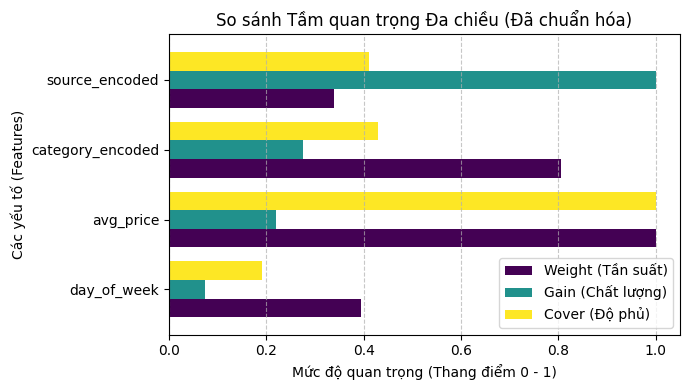

In [76]:
import matplotlib.pyplot as plt

# 1. Lấy dữ liệu thô từ Model
# XGBoost cho phép lấy từng loại điểm số ra dưới dạng Dictionary
weight_score = model.get_booster().get_score(importance_type='weight')
gain_score   = model.get_booster().get_score(importance_type='gain')
cover_score  = model.get_booster().get_score(importance_type='cover')

# 2. Gộp lại thành bảng DataFrame
# Index là tên các features
df_imp = pd.DataFrame({
    'Weight (Tần suất)': pd.Series(weight_score),
    'Gain (Chất lượng)': pd.Series(gain_score),
    'Cover (Độ phủ)': pd.Series(cover_score)
})

# Điền số 0 cho những feature nào bị thiếu (ít khi xảy ra nhưng cứ chắc ăn)
df_imp = df_imp.fillna(0)

# 3. CHUẨN HÓA DỮ LIỆU (QUAN TRỌNG)
# Vì Weight = 2000 còn Gain = 50, nên ta chia cho giá trị lớn nhất của từng cột
# Để đưa tất cả về thang đo từ 0 đến 1 (Relative Importance)
df_normalized = df_imp / df_imp.max()

# 4. Vẽ biểu đồ

# kind='barh': Biểu đồ thanh ngang
# width=0.8: Độ dày của nhóm thanh
df_normalized.sort_values(by='Gain (Chất lượng)', ascending=True).plot(
    kind='barh', 
    width=0.8,
    figsize=(7, 4),
    title='So sánh Tầm quan trọng Đa chiều (Đã chuẩn hóa)',
    colormap='viridis' # Chọn màu cho đẹp
)

plt.xlabel('Mức độ quan trọng (Thang điểm 0 - 1)')
plt.ylabel('Các yếu tố (Features)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

Dựa vào biểu đồ trên ta có thể nhận định:
- Giá cả: đây là yếu tố được XGBoost dùng để phân nhánh nhiều nhất, tuy nhiên sự thay đổi về giá cũng sẽ ảnh hưởng ko quá nhiều dến số lượng bán được (gain thấp). Nên thay vì tập trung về điều chỉnh giá, chúng ta hãy tập trung vào yếu tố khác để tối ưu doanh số.
- Loại sản phẩm: cũng là một yếu tốt khá đại trà ảnh hưởng đến số lượng bán. Tuy nhiên, tương tự như giá cả, yếu tố này cũng ảnh ko nhiều đến doanh số như yếu tố tiếp theo.
- Nguồn traffic: Tuy không đại trà như 2 yếu tố trên, sự ảnh hưởng lên doanh số của traffic source lại cao hơn đáng kể hơn tất cả các yếu tố còn lại. Chứng tỏ rằng, để tối ưu về doanh số, người bán hàng nên tập trung tối ưu về traffic source.
- Ngày trong tuần: Đây là feature ảnh hướng yếu nhất đến doanh số. Người kinh doanh không nên để ý đến yếu tố này.